<a id="top"></a>
# Team 5 Unsupervised Predict Notebook
### Kaggle Submission: 2110ACDS_T5


**Team Members:** Melania Makombe , Abubakar Sadiq,Christian Divinefavour, Nuraddeen Isah and Michael Kanu
**Supervisor:** Maryam Hassan

* [Notebook repo](https://github.com/abubakaralsadiq/Unsupervised_Learning-Team_5)
* [Streamlit repo](https://github.com/Lizette95/unsupervised-predict-streamlit-template)
* [Trello board](https://trello.com/b/nHi642IR/recomendermodel) 
* [Comet_ML](https://www.comet.ml/tsikaapp/team-5-unsupervised-ml/view/new/panels) 


<a id="intro"></a>
## 1. Introduction  

### Background
On the internet, where the number of choices is overwhelming, there is a need to filter, prioritize and efficiently deliver relevant information in order to reduce the problem of information overload, which has created a potential problem for many Internet users. Recommender systems solve this problem by searching through a large volume of dynamically generated information to provide users with personalized content and services. 

Recommender systems are the systems that are designed to recommend things to the user based on many different factors. These systems predict the most likely product that the users are most likely to purchase and are of interest to. Companies like Netflix, Amazon, etc. use recommender systems to help their users to identify the correct product or movies for them. 

The recommender system deals with a large volume of information present by filtering the most important information based on the data provided by a user and other factors that take care of the user’s preference and interest. It finds out the match between user and item and imputes the similarities between users and items for recommendation

Recommender systems are beneficial to both service providers and users. They reduce transaction costs of finding and selecting items in an online shopping environment. Recommendation systems have also proved to improve decision making process and quality.

Our client, DSTV is a Sub-Saharan African direct broadcast satellite service owned by MultiChoice. Since Netflix implemented the recommender system on its platforms, DSTV has lost its clientele. DSTV conducted research to understand their problem.   In the research, 69% of the consumers that were surveyed said  that video streaming services like Netflix offer better value for money than traditional pay-TV services like MultiChoice's DStv. DSTV would like to retain and improve the amount of customers using its platform by introducing its own movie streaming service. With that they will increase choice for their clients and become more entertaining. 

As such, our company, Strata statistics consultants was hired to create a content based and collaborative based filtering movie recommender models that will be used in this streaming app. 

### Problem Statement
The main objective of this project is to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences.


#### Content-based filtering

This method makes recommendations based on user preferences for product features. It is able to recommend new items, but is limited by the need for more data of user preference to improve the quality of recommendations.

#### Collaborative filtering

Collaborative filtering mimics user-to-user recommendations. In other words, If you and your friend have similar tastes, you are likely to make recommendations the other would approve of. This method finds similar users and predicts their preferences as a linear, weighted combination of other user preferences. The limitation is the requirement of a large dataset with active useres who rated a product before in order to make accurate predictions. As a result of this limitation, collaborative systems usually suffer from the "cold start" problem, making predictions for new users challenging. This is usually overcome by using content-based filtering to initiate a user profile.

#### Hybrid systems

A combination of these two recommendations systems is called a hybrid system. They mix the features of the item itself and the preferences of other users [[2]](#ref2).



<a id="imports"></a>
## 2. Load Dependencies

### Connecting to Comet

In [55]:
# Link workspace to Comet experiment
# !pip install comet_ml
from comet_ml import Experiment
# Create an experiment with your api key
experiment = Experiment(
    api_key="rhxOl6OrextNazWTBlB2j8YNW",
    project_name="team-5-unsupervised-ml",
    workspace="tsikaapp",
)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/tsikaapp/team-5-unsupervised-ml/6fbf7c134b04483f81ae78d7fe259915
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     os packages                  : 1
COMET INFO:     source_code                  : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Cou

### Libriaries

In [1]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

# Install Prerequisites
# import sys
# !{sys.executable} -m pip install scikit-learn scikit-surprise
# !pip install git+https://github.com/gbolmier/funk-svd

# Exploratory Data Analysis
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
import random
from time import time
import cufflinks as cf
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Models
from surprise import Reader, Dataset
from surprise import SVD,SVDpp, NormalPredictor, BaselineOnly, NMF, SlopeOne, CoClustering
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Performance Evaluation
from surprise import accuracy
from sklearn.metrics import mean_squared_error
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

# Display
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")
pd.set_option('display.max_columns', 37)

### Data

#### Train and test data:
This is the data used for training and Kaggle submission purposes. The rating is the target variable.

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df.shape, test_df.shape)
train_df.head(3)

(10000038, 4) (5000019, 2)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539


It is noted that the train data includes an additional column "timestamp" This data can be safely dropped as there is no reasonable link between the time someone watches a movie and whether or not they rate it favourably.

#### Movie Data:

In [3]:
movies_df =  pd.read_csv('movies.csv', index_col='movieId')
imdb_df =  pd.read_csv('imdb_data.csv', index_col='movieId')
links_df =  pd.read_csv('links.csv', index_col='movieId')
genome_scores =  pd.read_csv('genome_scores.csv', index_col='movieId')
genome_tags =  pd.read_csv('genome_tags.csv', index_col='tagId')
tags =  pd.read_csv('tags.csv')
print(movies_df.shape, imdb_df.shape, links_df.shape, genome_scores.shape, genome_tags.shape)

(62423, 2) (27278, 5) (62423, 2) (15584448, 2) (1128, 1)


### Data Definitions

**Numeric**
* **budget:** - (continuous) dollar cost of production of the movie.
* **rating:** - (discrete) users rating of a movie from. **TARGET**
* **relevance:** - (continuous) measure (0-1) of the relevance of a genome tag to the movie, where 1 impies 100% relevance.
* **runtime:** - (continuos) movie duration in minutes.
* **timestamp:** - (continuous) the time at which a user rated the movie.


**Categorical**
* **director:** - (nominal) the person who controls the making of a film and supervises the actors and technical crew.
* **genres:** - (nominal) the style or category of the movie. A movie may belong to multiple (up to nineteen) genres, or may be absent a genre listing.
* **imdbId:** - (nominal) unique indentifying key for each IMBD entry. Can also be used in conjunction with the TMDB API.
* **movieId:** - (nominal) a unique identifier for each movie. There are 48,213 unique movies.
* **plot_keywords:** - (nominal) key words used to identify characteristics of a movie's storyline.
* **tag:** - (nominal) genome label
* **tagId:** - (nominal) unique genome identifier.
* **tmdbId:** - (nominal) unique identifier that works in conjunction with the TMDB API.
* **title:** - (nominal) the unique title identifying the movie. Included is a year of release enclosed in parenthesis at the end of the title.
* **title_cast:** - (nominal) the actors of the main characters in the movie. This does not include extras.
* **userId:** - (nominal) a unique identifier for each user. There are 162,541 unique users.

*The Movie Genome concept is borrowed from the Human Genome Project, a scientific project to identify and map all human genes. Similarly, a Movie Genome identifies and indexes multiple “genes” (elements and aspects) of a movie.*

<a id="EDA"></a>
## 3. Exploratory Data Analysis

### Data Summary

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [6]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62423 entries, 1 to 209171
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   62423 non-null  object
 1   genres  62423 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [7]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27278 entries, 1 to 131262
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title_cast     17210 non-null  object 
 1   director       17404 non-null  object 
 2   runtime        15189 non-null  float64
 3   budget         7906 non-null   object 
 4   plot_keywords  16200 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.2+ MB


In [8]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62423 entries, 1 to 209171
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   imdbId  62423 non-null  int64  
 1   tmdbId  62316 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.4 MB


In [9]:
genome_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15584448 entries, 1 to 206499
Data columns (total 2 columns):
 #   Column     Dtype  
---  ------     -----  
 0   tagId      int64  
 1   relevance  float64
dtypes: float64(1), int64(1)
memory usage: 356.7 MB


In [10]:
genome_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128 entries, 1 to 1128
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tag     1128 non-null   object
dtypes: object(1)
memory usage: 17.6+ KB


### Missing Values

In [11]:
print("Train: ")
print(str(train_df.isnull().sum()))
print("============")
print("Test: ")
print(str(test_df.isnull().sum()))
print("============")
print("Movies: ")
print(str(movies_df.isnull().sum()))
# print("============")
# print("Tags: ")
# print(str(tags_df.isnull().sum()))
print("============")
print("Links: ")
print(str(links_df.isnull().sum()))
print("============")
print("IMDB: ")
print(str(imdb_df.isnull().sum()*100/ len(imdb_df)))
print("============")
print("Genome scores: ")
print(str(genome_scores.isnull().sum()))
print("============")
print("Genome tags: ")
print(str(genome_tags.isnull().sum()))

Train: 
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Test: 
userId     0
movieId    0
dtype: int64
Movies: 
title     0
genres    0
dtype: int64
Links: 
imdbId      0
tmdbId    107
dtype: int64
IMDB: 
title_cast       36.908864
director         36.197668
runtime          44.317765
budget           71.016937
plot_keywords    40.611482
dtype: float64
Genome scores: 
tagId        0
relevance    0
dtype: int64
Genome tags: 
tag    0
dtype: int64


In [12]:
# Drop missing rows
# tags_df.dropna(axis=0,inplace=True)
links_df.dropna(axis=0,inplace=True)

In [13]:
# Drop duplicate movie titles?
#movies_df.drop_duplicates(subset="title", keep=False, inplace=True)

### Ratings

Q: Which users have rated the most movies?

In [14]:
def user_ratings_count(df, n):
    """
    Counts the number of user ratings.
    Parameters
    ----------
        df (DataFrame): input DataFrame
        n (int): number of users to show
    Returns
    -------
        barplot (NoneType): barplot of top n users by number of observations
    Example
    -------
        >>> df = pd.DataFrame({'userId':[1,2,3,1,2,4,5,4]})
        >>> user_ratings_count(df, 3)
            NoneType (barplot)
    """
    plt.figure(figsize=(8,6))
    data = df['userId'].value_counts().head(n)
    ax = sns.barplot(x = data.index, y = data, order= data.index, color='red', edgecolor="red")
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=11, ha='center', va='bottom')
    plt.title(f'Top {n} Users by Number of Ratings', fontsize=14)
    plt.xlabel('User ID')
    plt.ylabel('Number of Ratings')
    print("Combined number of ratings:\t",df['userId'].value_counts().head(n).sum(),
         "\nTotal number of movies:\t\t", df['movieId'].nunique())
    plt.show()

Combined number of ratings:	 34398 
Total number of movies:		 48213


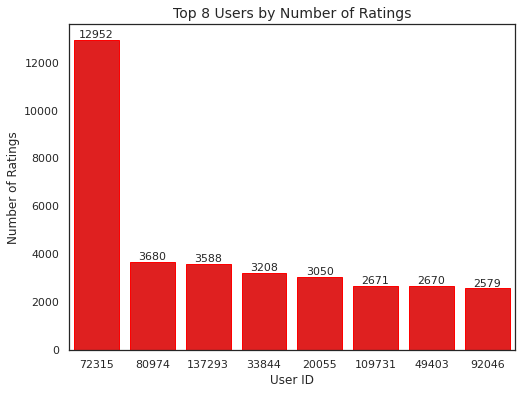

In [15]:
user_ratings_count(train_df,8)

Fig 1. User 72315 has rated an extreme number of movies relative to other users. For EDA purposes, this user is removed to make interpretation easier.

In [16]:
# Exclude user 72315 for EDA
eda_df = train_df[train_df['userId']!=72315]

Combined number of ratings:	 23734 
Total number of movies:		 45844


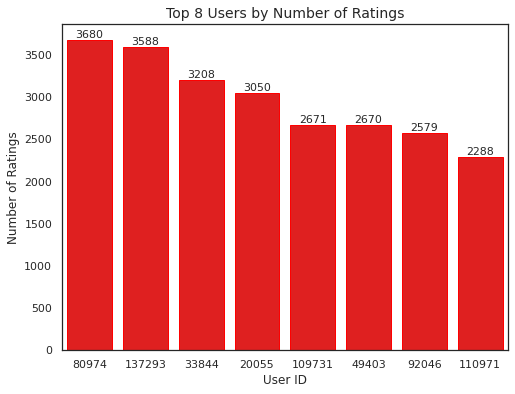

In [17]:
user_ratings_count(eda_df,8)

In [18]:
# How many ratings have we lost?
34398-23734

10664

In [19]:
# How many movies were only rated by our outlier?
48213-45844

2369

Our outlier user clearly rated quite a few movies. The loss of unique ratings indicates that he could've been the only person watching those movies. This would cause the recommender to use him as a baseline for those movies.

Q: How do users tend to rate movies?

In [20]:
def ratings_distplot(df, column='rating'):
    """
    Plots the distribution of ratings in the dataset.
    Parameters
    ----------
        df (DataFrame): input DataFrame
        column (str): column to plot
    Returns
    -------
        distplot (NoneType): distplot of rating frequencies
    """
    plt.figure(figsize=(8,6))
    ax = sns.distplot(df[f'{column}'],bins=10, kde=False, hist_kws=dict(alpha=0.6),color="#FFCCCB")
    mean = df[f'{column}'].mean()
    median = df[f'{column}'].median()
    plt.axvline(x=mean, label = f'mean {round(mean,2)}' , color='#4D17A0', lw=3, ls = '--')
    plt.axvline(x=median, label = f'median {median}' , color='#4DA017', lw=3, ls = '--')
    plt.xlim((0.5,5))
    plt.ylim((0,2500000))
    plt.title(f'Distribution of Ratings', fontsize=14)
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

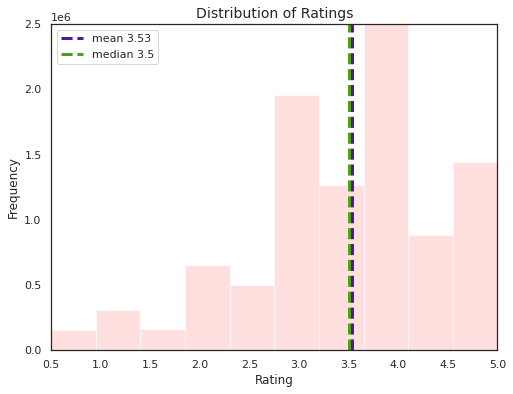

In [21]:
ratings_distplot(eda_df)

It is interesting that the ratings are left-skewed. It was expected that there would be a normal distrubtion with a mean rating of 3. Instead, we observe that users tend to rate movies quite favourably and tend to avoid negative ratings. This skew might be explained by the tendency of users to rate movies they liked. In other words, if a user doesn't like a movie, it is unlikely that they will watch it through to the end, let alone rate it.

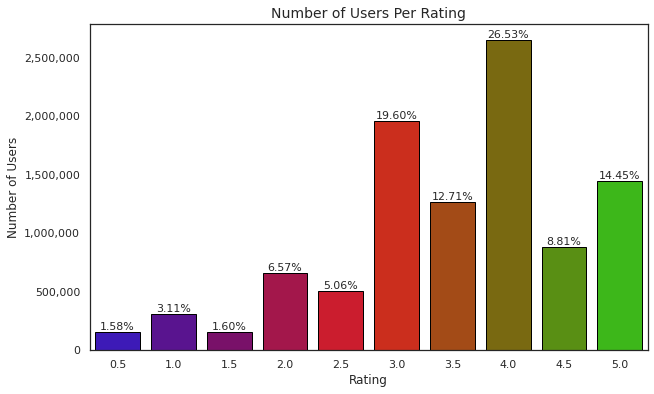

In [30]:
movieRatingDistGroup = train_df['rating'].value_counts().sort_index().reset_index()
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=movieRatingDistGroup, x='index', y='rating', palette="brg", edgecolor="black", ax=ax)
ax.set_xlabel("Rating")
ax.set_ylabel('Number of Users')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
total = float(movieRatingDistGroup['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+350, '{0:.2%}'.format(height/total), fontsize=11, ha="center", va='bottom')
plt.title('Number of Users Per Rating', fontsize=14)
plt.show()

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
gen = movies_df['genres'].explode()
text = list(set(gen))
plt.rcParams['figure.figsize'] = (13, 13)
wordcloud = WordCloud(max_font_size=50, max_words=100,background_color="#FFD6CD").generate(str(text))

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Ploting top genres in the Dataset
plt.figure(figsize=(20, 10))
gen = movies_df['genres'].explode()
ax=sns.countplot(x=gen, order=gen.value_counts().index[:30],color='red')
ax.set_title('Top Genres', fontsize=15)
plt.xticks(rotation =90)
plt.show()

Drama is the most commonly occuring genre with almost half of the movies identifying itself as a drama film. Comedy comes in at a distant second with 25% of the movies having adequate doses of humor. Other major genres in the top 10 are Thriller, Romance,Action, Horror, Documentary and Crime.


## Movies per year

The dataset has 48213 movies available to us. it is reasonable to assume that it does include almost every major film released during those years with this assumptions in mind, let us take a look at the number of movies produced by the year.


## Tags
These tags allows users to attach free plot keywords.

In [31]:
tagg = tags['tag']
tagg.dropna(inplace=True)

<function matplotlib.pyplot.show(close=None, block=None)>

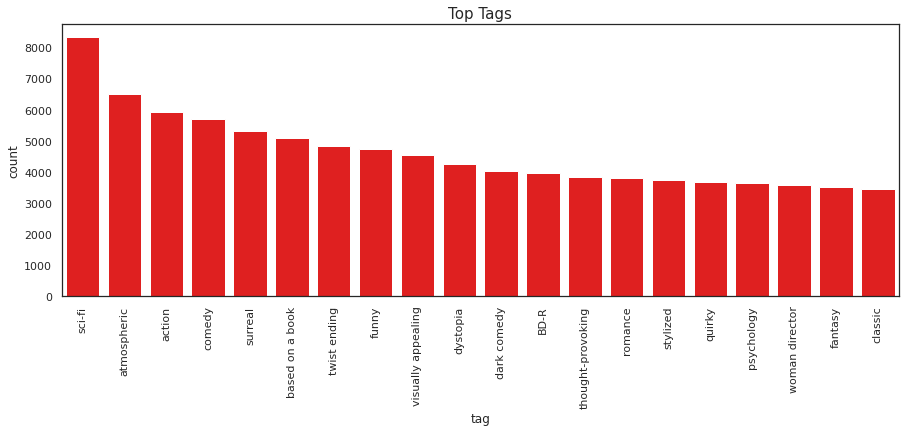

In [32]:
#Plot tags 
plt.figure(figsize=(15, 5))
ax = sns.countplot(x=tagg, order = tagg.value_counts().index[:20],color = 'red')
ax.set_title('Top Tags', fontsize=15)
plt.xticks(rotation=90)
plt.show

##  Casts
Let us now take a look at the cast of our movies.

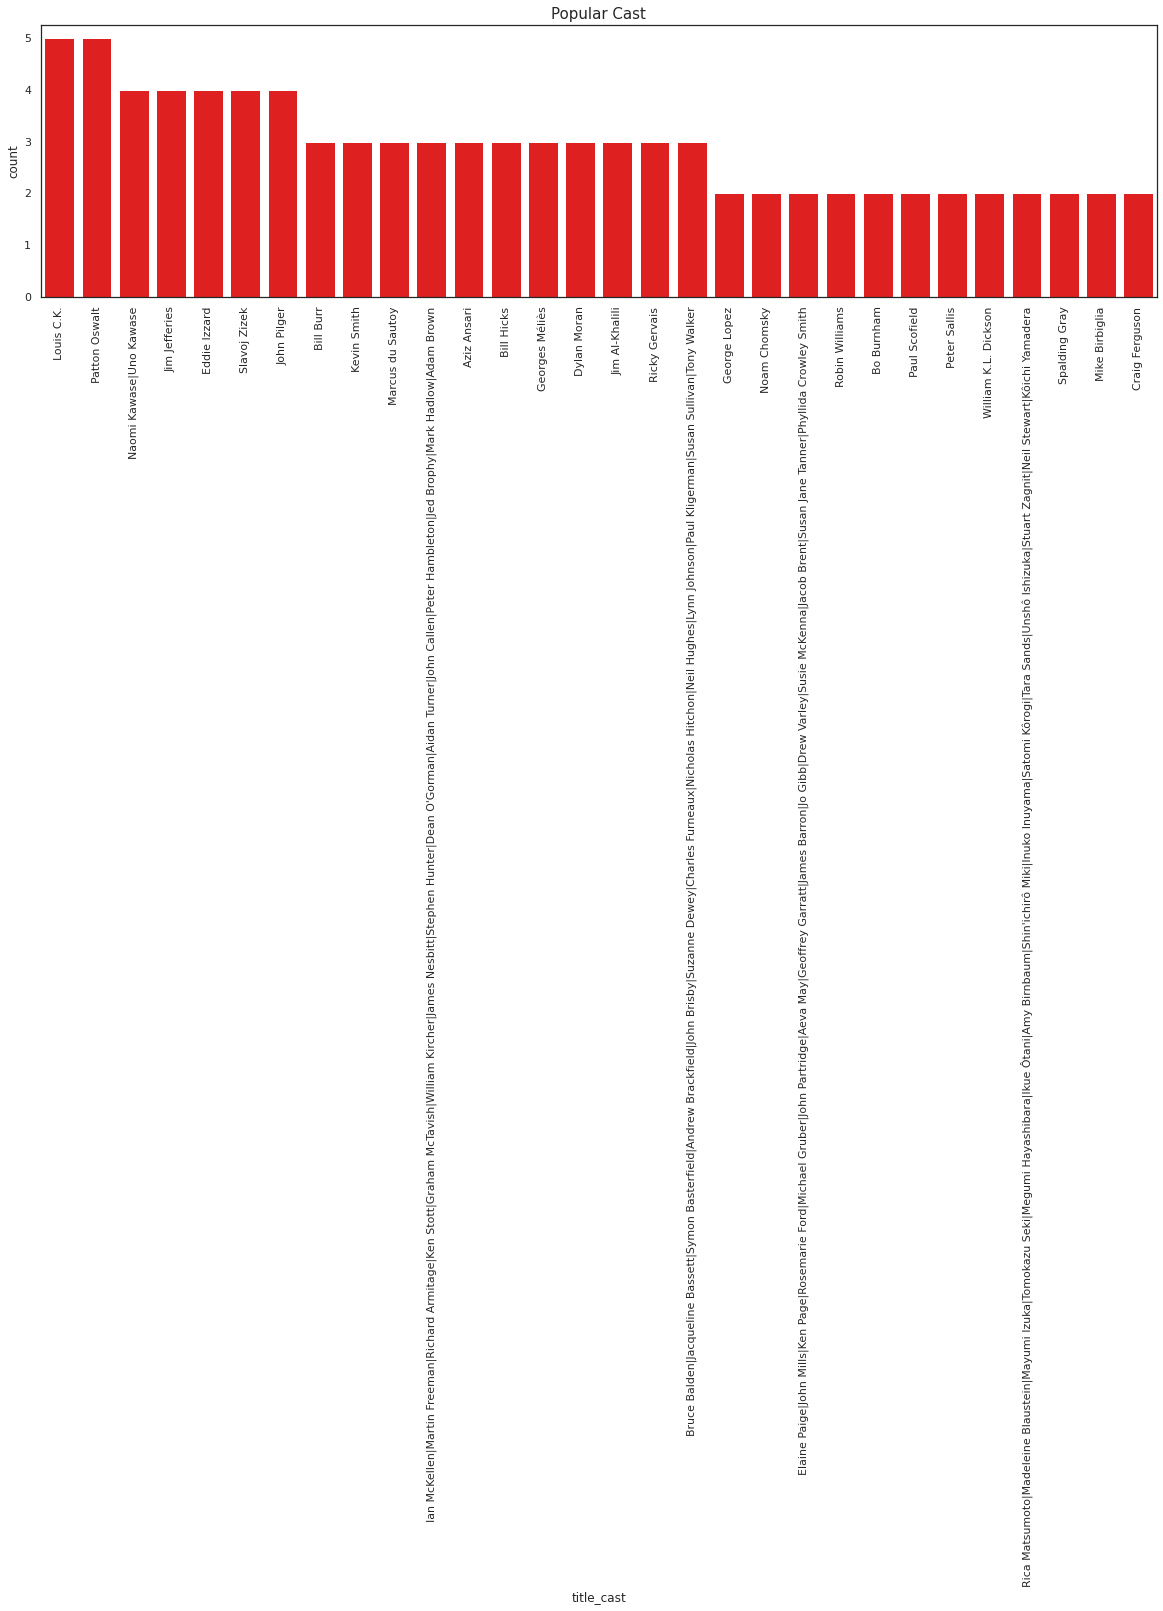

In [33]:
# Plot popular cast
plt.figure(figsize = (20,5))
cast=imdb_df['title_cast'].explode()
ax=sns.countplot(x=cast, order = cast.value_counts().index[:30],color='red')
ax.set_title('Popular Cast',fontsize=15)
plt.xticks(rotation=90)
plt.show()

## Movie

Most porpular and lease porular movies 

In [34]:
def plot_ratings(count, n, color='#4DA017', best=True, method='mean'):
    """
    Make scatterplots of ratings.
    Parameters
    ----------
        count (int): number of ratings threshold
        n (int): number of movies
        color (str): plot colour
        best (bool): column to plot
        method (str): statistical measure
    Returns
    -------
        scatterplot (NoneType): scatterplot of mean number of ratings
    """
    # What are the best and worst movies
    # Creating a new DF with mean and count
    if method == 'mean':
        movie_avg_ratings = pd.DataFrame(eda_df.join(movies_df, on='movieId', how='left').groupby(['movieId', 'title'])['rating'].mean())
    else:
        movie_avg_ratings = pd.DataFrame(eda_df.join(movies_df, on='movieId', how='left').groupby(['movieId', 'title'])['rating'].median())
    movie_avg_ratings['count'] = eda_df.groupby('movieId')['userId'].count().values
    movie_avg_ratings.reset_index(inplace=True)
    movie_avg_ratings.set_index('movieId', inplace=True)

    # Remove movies that have been rated fewer than n times
    data = movie_avg_ratings[movie_avg_ratings['count']>count]
    data.sort_values('rating', inplace= True,ascending=False)
    if best == True:
        plot = data.head(n).sort_values('rating', ascending=True)
        title='Best Rated'
    else:
        plot = data.tail(n).sort_values('rating', ascending=False)
        title='Worst Rated'
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=plot['rating'], y=plot['title'], size=plot['count'], color=color)
    plt.xlabel('Rating')
    plt.ylabel('')
    plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
    plt.title(f'Top {n} {title} Movies with Over {count} Ratings', fontsize=14)
    plt.show()

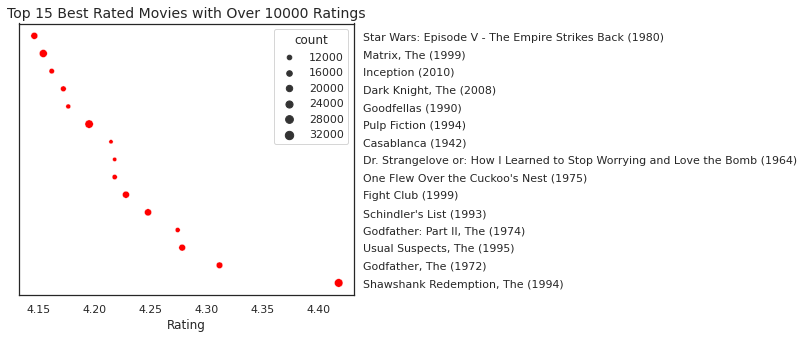

In [35]:
# What are the top 10 highest rated titles?
plot_ratings(10000, 15, 'red', True, 'mean')

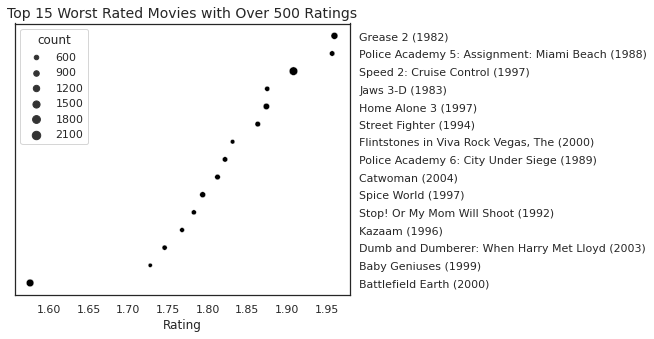

In [26]:
# What are the 10 worst rated titles?
plot_ratings(500, 15,'black', False, 'mean')

<a id="preprocessing"></a>
## 4. Data Preprocessing

Data Preparation is one of the indispensable steps in any Machine Learning development life cycle. In today’s world, the data is present in a structured as well as unstructured form. To deal with such data, data scientists spent almost 70–80% of their time in preparing data for further analysis. [Data Preprocessing steps in Python for any Machine Learning Algorithm](https://medium.com/@prtk13061992/data-preprocessing-steps-in-python-for-any-machine-learning-algorithm-2d52b57fa098)


### Multidimensional Scaling
Multidimensional scaling (MDS) is a technique for visualizing distances between objects on a map, where the distance is known between pairs of the objects.  
> "The t-SNE algorithm comprises two main stages. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects have a high probability of being picked, whilst dissimilar points have an extremely small probability of being picked. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the two distributions with respect to the locations of the points in the map. Note that whilst the original algorithm uses the Euclidean distance between objects as the base of its similarity metric, this should be changed as appropriate." [[3]](#ref3)

In [ ]:
# Subset the data to cut down computation time for now
#genome_score = genome_scores[:10000000]

In [ ]:
# Although scores are in the range of 0-1, there is no harm in scaling
#scaler_mds = StandardScaler()
#mds_genome = scaler_mds.fit_transform(genome_score.sample(frac=0.0001))

<a id="modelling"></a>
## 5. Modelling

To reduce computation time, we train and evaluate the following models on a 100k subset of the data. The best performing model will be trained on the whole dataset to predict the ratings for the final submission file.

In [ ]:
# Load the 100k dataset
train_df.drop('timestamp', axis=1, inplace=True)
train_subset = train_df[:100000]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

### Collaborative Filtering

Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user [[5]](#ref5).

From the Suprise library, the follwoing algorithms were used:

### Basic algorithms
***NormalPredictor:*** this algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal.

***BaselineOnly:*** this algorithm predicts the baseline estimate for given user and item.

### k-NN algorithms
***KNNBasic:*** this is a basic collaborative filtering algorithm.

***KNNWithMeans:*** this is a basic collaborative filtering algorithm, taking into account the mean ratings of each user.

***KNNWithZScore:*** this is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

***KNNBaseline:*** is a basic collaborative filtering algorithm taking into account a baseline rating.

### Matrix Factorization-based algorithms
***SVD:*** this algorithm is equivalent to Probabilistic Matrix Factorization ( which makes use of data provided by users with similar preferences to offer recommendations to a particular user).

***SVDpp:*** this algorithm is an extension of SVD that takes into account implicit ratings.

***NMF:*** this is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

***SlopeOne:*** this is a straightforward implementation of the SlopeOne algorithm.

***Coclustering:*** is a collaborative filtering algorithm based on co-clustering.


#### SVD

The Singular Value Decomposition algorithm is a matrix factorization technique which reduces the number of features of a dataset and was popularized by Simon Funk during the [Neflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize) contest [[6]](#ref6). In the matrix structure, each row represents a user and each column represents a movie. The matrix elements are ratings that are given to movies by users.

In [ ]:
#svd model 
svd_test = SVD(n_epochs = 30, n_factors = 200, init_std_dev = 0.05, random_state=42)

# Fitting the model 
svd_test.fit(trainset)

# making prediction on the validation dataset 
predictions = svd_test.test(testset)

# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)

#### SVDpp

The Singular Value Decomposition algorithm 

In [ ]:

#SVDpp model
svdpp=SVDpp(n_epochs = 40, n_factors = 400, init_std_dev = 0.05, random_state=42)

#Fitting the model
svdpp.fit(trainset)

# Making prediction on the validation dataset
test_pred= svdpp.test(testset)

#Evaluating model performance
rsme_svdpp = accuracy.rmse(test_pred)

#### NormalPredictor  
The Normal Predictor algorithm predicts a random rating for each movie based on the distribution of the training set, which is assumed to be normal.

In [ ]:
np_test = NormalPredictor()
np_test.fit(trainset)
predictions = np_test.test(testset)
# Calculate RMSE
np_rmse = accuracy.rmse(predictions)

#### BaselineOnly  
The Baseline Only algorithm predicts the baseline estimate for a given user and movie. A baseline is calculated using either Stochastic Gradient Descent (SGD) or Alternating Least Squares (ALS).

In [ ]:
bsl_options = {'method': 'sgd','n_epochs': 40}
blo_test = BaselineOnly(bsl_options=bsl_options)
blo_test.fit(trainset)
predictions = blo_test.test(testset)
# Calculate RMSE
blo_rmse = accuracy.rmse(predictions)

#### NMF  
NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. The optimization procedure is a (regularized) stochastic gradient descent with a specific choice of step size that ensures non-negativity of factors, provided that their initial values are also positive.

In [ ]:
nmf_test = NMF()
nmf_test.fit(trainset)
predictions = nmf_test.test(testset)
# Calculate RMSE
nmf_rmse = accuracy.rmse(predictions)

#### SlopeOne  
The SlopeOne algorithm is a simple yet accurate collaborative filtering algorithm that uses a simple linear regression model to solve the data sparisity problem. 

In [ ]:
slo_test = SlopeOne()
slo_test.fit(trainset)
predictions = slo_test.test(testset)
# Calculate RMSE
slo_rmse = accuracy.rmse(predictions)

#### CoClustering  
The Co-clustering algorithm assigns clusters using a straightforward optimization method, much like k-means.

In [ ]:
cc_test = CoClustering(random_state=42)
cc_test.fit(trainset)
predictions = cc_test.test(testset)
# Calculate RMSE
cc_rmse = accuracy.rmse(predictions)

KNN 

In [ ]:

#knn model
knn_baseline=KNNBaseline(random_state=42)

#Fitting the model
knn_baseline.fit(trainset)

# Making prediction on the validation dataset
test_pred_k= knn_baseline.test(testset)

#Evaluating model performance
rsme_knn_k = accuracy.rmse(test_pred_k)

In [ ]:
#knn model
knn_basic=KNNBasic(n_neighbors = 5, weights = 'uniform',algorithm = 'brute',metric = 'minkowski')

#Fitting the model
knn_basic.fit(trainset)

# Making prediction on the validation dataset
test_pred_kb= knn_basic.test(testset)

#Evaluating model performance
rsme_knn_kb = accuracy.rmse(test_pred_kb)

In [ ]:
#knn model
knn_wz= KNNWithZScore(n_neighbors = 5, weights = 'uniform',algorithm = 'brute',metric = 'minkowski')

#Fitting the model
knn_wz.fit(trainset)

# Making prediction on the validation dataset
test_pred_kwz= knn_wz.test(testset)

#Evaluating model performance
rsme_knn_kwz = accuracy.rmse(test_pred_kwz)

In [ ]:
#knn model
knn_wm=KNNWithMeans(n_neighbors = 5, weights = 'uniform',algorithm = 'brute',metric = 'minkowski')

#Fitting the model
knn_wm.fit(trainset)

# Making prediction on the validation dataset
test_pred_kwm= knn_wm.test(testset)

#Evaluating model performance
rsme_knn_kwm = accuracy.rmse(test_pred_kwm)

### Content-based Filtering  
Content-based filtering, also referred to as cognitive filtering, recommends items based on a comparison between the content of the items and a user profile. The content of each item is represented as a set of descriptors or terms, typically the words that occur in a document [[7]](#ref7). In the following section, the model uses genres as keywords to recommend similar movies based on input from a user. The model was not used to predict ratings for the testing data, as it is too computationally expensive.

In [ ]:
def data_preprocessing(subset_size):
    """Prepare data for use within Content filtering algorithm.

    Parameters
    ----------
    subset_size : int
        Number of movies to use within the algorithm.

    Returns
    -------
    Pandas Dataframe
        Subset of movies selected for content-based filtering.

    """
    # Split genre data into individual words.
    movies['keyWords'] = movies['genres'].str.replace('|', ' ')
    # Subset of the data
    movies_subset = movies[:subset_size]
    return movies_subset
 
def content_model(movie_list,top_n=10): 
    """Performs Content filtering based upon a list of movies supplied
       by the app user.

    Parameters
    ----------
    movie_list : list (str)
        Favorite movies chosen by the app user.
    top_n : type
        Number of top recommendations to return to the user.

    Returns
    -------
    list (str)
        Titles of the top-n movie recommendations to the user.

    """
    # Initializing the empty list of recommended movies
    data = data_preprocessing(2000)
    # Instantiating and generating the count matrix
    count_vec = CountVectorizer()
    count_matrix = count_vec.fit_transform(data['keyWords'])
    indices = pd.Series(data['title'])
    cosine_sim = cosine_similarity(count_matrix, count_matrix)
    cosine_sim = pd.DataFrame(cosine_sim, index = data.index, columns = data.index)
    # Getting the index of the movie that matches the title
    idx_1 = indices[indices == movie_list[0]].index[0]
    idx_2 = indices[indices == movie_list[1]].index[0]
    idx_3 = indices[indices == movie_list[2]].index[0]
    # Creating a Series with the similarity scores in descending order
    rank_1 = cosine_sim[idx_1]
    rank_2 = cosine_sim[idx_2]
    rank_3 = cosine_sim[idx_3]
    # Calculating the scores
    score_series_1 = pd.Series(rank_1).sort_values(ascending = False)
    score_series_2 = pd.Series(rank_2).sort_values(ascending = False)
    score_series_3 = pd.Series(rank_3).sort_values(ascending = False)
    # Getting the indexes of the 10 most similar movies
    listings = score_series_1.append(score_series_2).append(score_series_3).sort_values(ascending = False)
    # Store movie names
    recommended_movies = []
    # Appending the names of movies
    top_50_indexes = list(listings.iloc[1:50].index)
    # Removing chosen movies
    top_indexes = np.setdiff1d(top_50_indexes,[idx_1,idx_2,idx_3])
    for i in top_indexes[:top_n]:
        recommended_movies.append(list(movies['title'])[i])
    return recommended_movies

In [ ]:
movies = movies_df.dropna()
movie_list = ['Grumpier Old Men (1995)','Ace Ventura: When Nature Calls (1995)','Father of the Bride Part II (1995)']
content_model(movie_list,top_n=10)

<a id="evaluation"></a>
## 6. Performance Evaluation

We built and tested six different collaborative filtering models and compared their performance using a statistical measure known as the root mean squared error (**RMSE**), which determines the average squared difference between the estimated values and the actual value. A low RMSE value indicates high model accuracy.

### Root Mean Squared Error (RMSE):
$$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$   

In [ ]:
# Compare RMSE values between models
fig,axis = plt.subplots(figsize=(8, 5))
rmse_x = ['SVD','SVDpp','NormalPredictor','BaselineOnly','NMF','SlopeOne','CoClustering']
rmse_y = [svd_rmse,rsme_svdpp,np_rmse,blo_rmse,nmf_rmse,slo_rmse,cc_rmse]
ax = sns.barplot(x=rmse_x, y=rmse_y,color='#FF073A',edgecolor='black')
plt.title('RMSE Value Per Collaborative-based Filtering Model',fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height(), round(p.get_height(),2), fontsize=12, ha="center", va='bottom')
    
plt.show()

### Cross Validation

Cross validation is a technique used to test the accuracy of a model's prediction on unseen data (validation sets). This is important because it can assist in picking up issues such as over/underfitting and selection bias. We used the K-fold technique to perform cross validation on our two best perfoming models, i.e. **SVD** and **BaselineOnly**.

**SVD**

In [ ]:
svd_test = SVD(n_epochs = 40, n_factors = 200, init_std_dev = 0.05, random_state=42)
# Run 5-fold cross-validation and print results
a = cross_validate(svd_test, data, measures=['RMSE'], cv=5, verbose=True)

In [ ]:
svdpp_test = SVDpp(n_epochs = 40, n_factors = 400, init_std_dev = 0.05, random_state=42)
# Run 5-fold cross-validation and print results
a = cross_validate(svdpp_test, data, measures=['RMSE'], cv=5, verbose=True)

**BaselineOnly**

In [ ]:
bsl_options = {'method': 'sgd','n_epochs': 40}
blo_test = BaselineOnly(bsl_options=bsl_options)
# Run 5-fold cross-validation and print results
b = cross_validate(blo_test, data, measures=['RMSE'], cv=5, verbose=True)

<a id="analysis"></a>
## 7. Model Analysis

In [ ]:
# Load the 100k dataset
train_subset = train_df[:100000]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

### Hyperparameter Tuning 

Hyperparameter tuning is the process by which a set of ideal hyperparameters are chosen for a model. A hyperparameter is a parameter for which the value is set manually and tuned to control the algorithm's learning process. We tested multiple parameters for our best performing model (i.e. **SVD**).

In [ ]:
param_grid = {'n_epochs':[30,40,50],
              'n_factors':[100,200,300,400],
              'init_std_dev':[0.001,0.005,0.05,0.1],
              'random_state':[42]} 
grid_SVD = GridSearchCV(SVD, cv=5, measures=['rmse'], param_grid=param_grid, n_jobs=-1)
grid_SVD.fit(data)
print('***Best score:***')
print(grid_SVD.best_score['rmse'])
print('***Best parameters:***')
print(grid_SVD.best_params['rmse'])

### Results

In [ ]:
svd_test = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42)
svd_test.fit(trainset)
predictions = svd_test.test(testset)
# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)

In [ ]:
# Predicted Target Values vs. Actual Target Values
new_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in testset:
    new_df.loc[i] = [uid, iid, rating]
    i = i+1
true = new_df['rating']
pred = []
for i in predictions:
    pred.append(i.est)
fig,axis = plt.subplots(figsize=(8, 5))
sns.boxplot(x=true, y=pred, color="#FF073A")
plt.title("Predicted Target Values vs. Actual Target Values", fontsize=14)
plt.xlabel("Actual Target Values")
plt.ylabel("Predicted Target Values")
plt.show()

In [ ]:
# params = {'n_epochs':40, #[30,40,50],
#           'n_factors':400, #[100,200,300],
#           'init_std_dev':0.005, #[0.005,0.05,0.1],
#           'random_state':[42]} 
# metrics = {"RMSE": np.sqrt(mean_squared_error(true, pred))}

# experiment.log_parameters(params)
# experiment.log_metrics(metrics)
# experiment.end()

<a id="conclusion"></a>
## 8. Conclusion
In this project, we succeeded in building an unsupervised machine learning model that is able to recommend movies based on content-based or collaborative filtering and is capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences. Our top performing model has a root mean squared error (RMSE) of 0.78, based on a testing set submitted to the EDSA [Kaggle](https://www.kaggle.com/c/edsa-recommender-system-predict/leaderboard) competition.  


The singular value decomposition (SVD) algorithm is a baseline approach to recommender systems, as it has a broad range of applications including dimensionality reduction, solving linear inverse problems, and data fitting. The SVD algorithm generally performs better on large datasets compared to some other models as it decomposes a matrix into constituent arrays of feature vectors corresponding to each row and each column.

<a id="save"></a>
## 9. Save Output

In [ ]:
# Train model on whole dataset
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()
svd = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42, verbose=True)
svd.fit(trainset)

# Create Kaggle submission file
predictions = []
for i, row in test_df.iterrows():
    x = (svd.predict(row.userId, row.movieId))
    pred = x[3]
    predictions.append(pred)
test_df['Id'] = test_df['userId'].map(str) +'_'+ test_df['movieId'].map(str)
results = pd.DataFrame({"Id":test_df['Id'],"rating": predictions})
results.to_csv("tesssst.csv", index=False)

In [ ]:
# Train model on whole dataset
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()
svd = SVDpp(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42, verbose=True)
svd.fit(trainset)

# Create Kaggle submission file
predictions = []
for i, row in test_df.iterrows():
    x = (svd.predict(row.userId, row.movieId))
    pred = x[3]
    predictions.append(pred)
test_df['Id'] = test_df['userId'].map(str) +'_'+ test_df['movieId'].map(str)
results = pd.DataFrame({"Id":test_df['Id'],"rating": predictions})
results.to_csv("tesst_svdpp.csv", index=False)

In [48]:
# Save model
# model_save_path = "SVD.pkl"
# with open(model_save_path,'wb') as file:
#     pickle.dump(svd,file)

In [49]:
 experiment.display()

In [ ]:
 experiment.end()

<a id="ref"></a>
## 10. References
<a id="ref1"></a>[1] Ansari, A. (n.d.). Internet Recommendation Systems. Retrieved August/September, 2000, from https://www0.gsb.columbia.edu/mygsb/faculty/research/pubfiles/385/Internet Recommendation Systems.pdf

<a id="ref2"></a>[2] Shi, C. (2017, June 27). A Hybrid Recommender with Yelp Challenge. Retrieved from https://nycdatascience.com/blog/student-works/yelp-recommender-part-1/

<a id="ref3"></a>[3] Wikipedia: t-distributed stochastic neighbor embedding. Retrieved from https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

<a id="ref4"></a>[4] Jolliffe, I.T. & Cadima, J. (2016, April 13). Principal component analysis: a review and recent developments. Retrieved from https://royalsocietypublishing.org/doi/10.1098/rsta.2015.0202

<a id="ref5"></a>[5] Ajitsaria, A. (n.d.). Build a Recommendation Engine With Collaborative Filtering. Retrieved from https://realpython.com/build-recommendation-engine-collaborative-filtering

<a id="ref6"></a>[6] Funk, S. (2006, Deccember 11). Netflix Update: Try This at Home. Retrieved from https://sifter.org/simon/journal/20061211.html

<a id="ref7"></a>[7] Recommender Systems: Content-based Filtering. Retrieved from http://recommender-systems.org/content-based-filtering/

[Back to top ↑](#top)